# Topic-Spesific Crawler (Text Only)
## Data Mining and Knowledge Discovery
## Dr. Saed Alqaraleh
## 2020-2021

### By: Yahya Tawil
### May 2021



In [ ]:
!pip install tldextract
!pip install transformers


In [ ]:
import csv
import ssl
import os
from urllib.request import Request, urlopen, URLError, urljoin
from urllib.parse import urlparse
import time
import threading
import queue
from bs4 import BeautifulSoup
from bs4.element import Comment
from pathlib import Path
import re
from datetime import datetime
from queue import PriorityQueue
from matplotlib import pyplot as plt
import tldextract
import hashlib
import requests
from google.colab import files as FILE
import pathlib
import pandas as pd

from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F

tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
model = AutoModel.from_pretrained('deepset/sentence_bert')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Script Settings ###
conf = dict(
    dir = '/content/drive/My Drive/crawler/Spider1/',
    imgsDir = "/content/drive/My Drive/crawler/Spider1/imgs/",
    base_url = ['https://www.worldhistory.org', # history 
                'https://www.newworldencyclopedia.org/', # history 
                'https://www.ushistory.org', # history 
                'https://www.historic-uk.com/', # history 
                'https://hbr.org/', # bussiness
                'https://newpol.org/', # politics
                'https://pc.net/', # technology
                'https://www.computerhope.com/', # technology
                'https://www.computerlanguage.com/'], # technology
    number_of_threads = 9,
    labels = ['technology','business','politics', 'history'],
    blacklist = ['facebook','instagram','youtube']
)

start_time = int(time.time())
crawled_csv = conf['dir']+'crawler_'+"{}.csv".format(start_time)
###

In [ ]:
speed_samples_10S = [] # number of total download pages 
speed_samples_10S_ctr = 0 # counter oh how many 10s sample we have
pages_count = 0

lck = threading.Lock()

#Delete the Crawler Directory to start from a clean dirctory
if os.path.exists(conf['dir']) is False:
  print("Create Directory")
  os.mkdir(conf['dir'])

if os.path.exists(conf['imgsDir']) is False:
  print("Create Imgs Directory")
  os.mkdir(conf['imgsDir'])

crawler_csv_file = open(crawled_csv, mode='a')  
crawlerFile_writer = csv.writer(crawler_csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
crawlerFile_writer.writerow(["timestamp","hash","link","post_text","downloaded_imgs","processed","label","true_label"])
pages_count = pages_count +1 
crawler_csv_file.close()

In [ ]:
class MyPriorityQueue(PriorityQueue):
    def __init__(self):
        PriorityQueue.__init__(self)
        self.counter = 0

    def put(self, item, priority):
        PriorityQueue.put(self, (priority, self.counter, item))
        self.counter += 1

    def get(self, *args, **kwargs):
        _, _, item = PriorityQueue.get(self, *args, **kwargs)
        return item

In [ ]:
class Classifier(threading.Thread):
  def __init__(self):
    threading.Thread.__init__(self)

  def get_label(self,sentence):
    # run inputs through model and mean-pool over the sequence
    # dimension to get sequence-level representations
    inputs = tokenizer.batch_encode_plus([sentence] + conf['labels'],
                                        return_tensors='pt',
                                        pad_to_max_length=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    output = model(input_ids, attention_mask=attention_mask)[0]
    sentence_rep = output[:1].mean(dim=1)
    label_reps = output[1:].mean(dim=1)

    # now find the labels with the highest cosine similarities to
    # the sentence
    similarities = F.cosine_similarity(sentence_rep, label_reps)
    closest = similarities.argsort(descending=True)
    # labels = []
    label =f"{conf['labels'][closest[0]]}:{similarities[closest[0]]},{conf['labels'][closest[1]]}:{similarities[closest[1]]}"
    # for ind in closest:
      # labels.append(f"{similarities[ind]}")
    return label
    # for ind in closest:
    #     print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')

  def run(self):
    time.sleep(15) # sleep 10 s until the downloader get some data 
    while True:
      # reading the csv file
      lck.acquire()
      df = pd.read_csv(crawled_csv,index_col=False)
      for i in range(0,len(df. index)):
        if df.loc[i, 'processed'] == "No":      
          df.loc[i, 'processed'] = 'Yes'

          sentence = df.loc[i, 'post_text']
          bert_sentence = ""
          splited_sentence = sentence.split(' ')
          if len(splited_sentence) > 200 :
            for word in splited_sentence[0:200]:
              bert_sentence = bert_sentence + ' ' + word 
            print(f"cut the sentence from {len(splited_sentence)} to {len(bert_sentence.split())}")
          else:
            bert_sentence = sentence

          labels = self.get_label(bert_sentence)

          df.loc[i, 'label'] = [labels]

          # new_csv = conf['dir']+'crawler_'+"{}_new_{}.csv".format(start_time,i)
          with open(crawled_csv, 'w') as f:
            df.to_csv(f,index=False)
          lck.release()
          i = i +1
          break 
        i = i +1 
        if i == len(df. index) - 1:
          time.sleep(10) # sleep 10 sec when there are no more enough data
      time.sleep(0.5)


In [ ]:
regular_express = re.compile(r"https?://(\.)?")

class Crawler(threading.Thread):
    def __init__(self,base_url,url_queue,have_visited, error_links,url_lock,thread_num):
       
        threading.Thread.__init__(self)
        print(f"Web Crawler worker {threading.current_thread()} has Started")
        self.base_url = base_url
        self.links_queue= url_queue
        self.have_visited = have_visited
        self.error_links = error_links
        self.url_lock = url_lock
        self.threadNo = thread_num

    def tag_visible(self,element): # to exclude the following tags content
        if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
            return False
        if isinstance(element, Comment):
            return False
        if re.match(r"[\n]+",str(element)): return False
        return True

    def run(self):     
        global lck 
        global pages_count
        my_ssl = ssl.create_default_context()    
        my_ssl.check_hostname = False
        my_ssl.verify_mode = ssl.CERT_NONE
        
        while True:
            now = datetime.now()
            timestamp = datetime.timestamp(now)
            #print("Queue Size {} in thread{}:".format(self.links_queue.qsize(),self.threadNo))
            link = self.links_queue.get()
            link = urljoin(self.base_url,link)  
            domain = tldextract.extract(link).domain
            if domain in conf['blacklist']:
              continue 

            domain_have_visited = self.have_visited.get(domain,0)
            if domain_have_visited == 0:
              domain_have_visited = []

            # if the link is None the queue is exhausted or the threads are yet
            # process the links.
            if link is None:
                break
            
            # if The link is already visited we break the execution unless it passed 24h since last visit.
            if len(domain_have_visited) != 0:
              find=[item for item in domain_have_visited if link in item]  
              if len(find)>0:
                find=tuple(find)
                if (now - find[0][1]).total_seconds() < 86400: # 86400 is 24H in secs, if the last visit time is less than 24h, then don't visit
                  # print(f"The link {link} is already visited")
                  continue
                else:
                    self.have_visited[domain].remove(find[0]) #remove the record, to add new one later

            try: 
                req = Request(link, headers= {'User-Agent': 'Mozilla/5.0'})   
                try:
                  response = urlopen(req, context=my_ssl)
                except:
                  continue
                    
                soup = BeautifulSoup(response.read(),"html.parser")
                text=soup.prettify()

                images = soup.findAll('img')
                # print(f"Total {len(images)} Image Found!")

                downloaded_imgs = []
                hash = int(hashlib.sha256(link.encode('utf-8')).hexdigest(), 16) % 10**8

                if len(images) != 0:
                  for i, image in enumerate(images):
                    try:
                        # In image tag ,searching for "data-srcset"
                        image_link = image["data-srcset"]
                          
                    # then we will search for "data-src" in img 
                    # tag and so on..
                    except:
                        try:
                            # In image tag ,searching for "data-src"
                            image_link = image["data-src"]
                        except:
                            try:
                                # In image tag ,searching for "data-fallback-src"
                                image_link = image["data-fallback-src"]
                            except:
                                try:
                                    # In image tag ,searching for "src"
                                    image_link = image["src"]
                                 # if no Source URL found
                                except:
                                    pass

                    try:
                      r = requests.get(image_link).content
                      # After checking above condition, Image Download start
                      extention = pathlib.Path(image_link).suffix
                      if extention == ".png" or extention == "jpg" :
                        with open(f"{conf['imgsDir']}{hash}_{i}.{extention}", "wb") as f:
                            downloaded_imgs.append(f"{hash}_{i}")
                            # print("img saved!")
                            f.write(r)
                            f.close()
                      else:
                        pass
                    except:
                      pass
                texts = soup.findAll(text=True)

                visible_texts = filter(self.tag_visible, texts)  
                text = u",".join(t.strip() for t in visible_texts)
                text = text.lstrip().rstrip()
                text = text.split(',')
                post_text = ''
                for sen in text:
                  if sen:
                    if len(sen.split(' ')) > 5: # Accept only texts with more than 5 words
                      sen = sen.rstrip().lstrip()
                      post_text += sen+' '
                if len(post_text.split(' ')) < 6:
                  continue      
                lck.acquire()
                crawler_csv_file = open(crawled_csv, mode='a')  
                crawlerFile_writer = csv.writer(crawler_csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                crawlerFile_writer.writerow([timestamp,hash,link,post_text,downloaded_imgs,"No","N/A"," "])
                pages_count = pages_count +1 
                crawler_csv_file.close()
                lck.release()
                
                if type(soup.find_all('a')) == 'NoneType':
                  print("No links found in this page!")
                  continue
                else:
                  for a_tag in soup.find_all('a'):      
                      links = a_tag.get("href")
                      if len(domain_have_visited) == 0:
                          self.links_queue.put(links,1)
                      else:
                          if (links not in domain_have_visited) :
                            # if (links.find('.html#') == -1): # do not crawl the intra document links
                            self.links_queue.put(links,1)
                
                # print(f"Adding {link} to the crawled list at {timestamp}")
                if len(domain_have_visited) != 0:
                  self.have_visited[domain].append((link,now))   
                else:
                  self.have_visited[domain] = [(link,now)]             
            except URLError as e:
                #print(f"URL {link} threw this error {e.reason} while trying to parse")
                self.error_links.append(link)
            finally:
                self.links_queue.task_done()

In [ ]:
def count_downloaded_pages():
    global speed_samples_10S_ctr
    threading.Timer(10, count_downloaded_pages).start()  
    speed_samples_10S.append(pages_count)
    speed_samples_10S_ctr = speed_samples_10S_ctr + 1 

    print("{} total pages downloaded till now & {} threads are active, {} x10 sec".format(pages_count,threading.active_count(),speed_samples_10S_ctr))

    #Each one hour of execution plot the number of download webpages
    if speed_samples_10S_ctr > 360:
      speed_samples_10S_ctr = 0 
      plt.plot(speed_samples_10S)
      plt.show()

    for i,thread in enumerate(crawler_threads):
      if thread.is_alive() == False and thread.name == "crawler":
      #   print("Thread No. {} is alive".format(i))
      # else:
        # print("Thread No. {} is dead ".format(i))
        crawler = Crawler(base_url = thread.base_url,
                  url_queue = thread.links_queue, 
                  have_visited= thread.have_visited,
                  error_links= thread.error_links,
                  url_lock=thread.url_lock,
                  thread_num = thread.threadNo)
        del crawler_threads[i] #remove the dead thread
        crawler.start()
        crawler_threads.append(crawler)  
        
        crawler.join()  
      elif thread.is_alive() == False and thread.name == "classifer":
          classifier = Classifier()
          classifier.name="classifer"
          del crawler_threads[i] #remove the dead thread
          classifier.start()
          crawler_threads.append(classifier)         


# Main

The Crawler has the following configuraions:
{'dir': '/content/drive/My Drive/crawler/Spider1/', 'imgsDir': '/content/drive/My Drive/crawler/Spider1/imgs/', 'base_url': ['https://www.worldhistory.org', 'https://www.newworldencyclopedia.org/', 'https://www.ushistory.org', 'https://www.historic-uk.com/', 'https://hbr.org/', 'https://newpol.org/', 'https://pc.net/', 'https://www.computerhope.com/', 'https://www.computerlanguage.com/'], 'number_of_threads': 9, 'labels': ['technology', 'business', 'politics', 'history'], 'blacklist': ['facebook', 'instagram', 'youtube']}
1 total pages downloaded till now & 10 threads are active, 1 x10 sec
Setup thread no.0 with the following settings:
base_url:https://www.worldhistory.org
Web Crawler worker <_MainThread(MainThread, started 140501402949504)> has Started
Setup thread no.1 with the following settings:
base_url:https://www.newworldencyclopedia.org/
Web Crawler worker <_MainThread(MainThread, started 140501402949504)> has Started
Setup thread no

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


123 total pages downloaded till now & 29 threads are active, 3 x10 sec
cut the sentence from 516 to 188
123 total pages downloaded till now & 29 threads are active, 4 x10 sec
123 total pages downloaded till now & 29 threads are active, 5 x10 sec
cut the sentence from 392 to 200
131 total pages downloaded till now & 29 threads are active, 6 x10 sec
cut the sentence from 357 to 200
132 total pages downloaded till now & 29 threads are active, 7 x10 sec
133 total pages downloaded till now & 29 threads are active, 8 x10 sec
141 total pages downloaded till now & 29 threads are active, 9 x10 sec
cut the sentence from 212 to 200
cut the sentence from 254 to 200
141 total pages downloaded till now & 29 threads are active, 10 x10 sec
cut the sentence from 429 to 200
cut the sentence from 2562 to 200
144 total pages downloaded till now & 29 threads are active, 11 x10 sec
cut the sentence from 679 to 200
150 total pages downloaded till now & 29 threads are active, 12 x10 sec
cut the sentence from 

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


cut the sentence from 1464 to 188
289 total pages downloaded till now & 29 threads are active, 60 x10 sec
cut the sentence from 680 to 200
291 total pages downloaded till now & 29 threads are active, 61 x10 sec
cut the sentence from 1215 to 200
292 total pages downloaded till now & 29 threads are active, 62 x10 sec
cut the sentence from 2869 to 200
294 total pages downloaded till now & 29 threads are active, 63 x10 sec
cut the sentence from 433 to 200
cut the sentence from 1737 to 200
296 total pages downloaded till now & 29 threads are active, 64 x10 sec
cut the sentence from 406 to 192
300 total pages downloaded till now & 29 threads are active, 65 x10 sec
cut the sentence from 230 to 200
cut the sentence from 653 to 200
301 total pages downloaded till now & 29 threads are active, 66 x10 sec
cut the sentence from 6401 to 200
cut the sentence from 382 to 202
303 total pages downloaded till now & 29 threads are active, 67 x10 sec
cut the sentence from 1444 to 200
cut the sentence from 

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


419 total pages downloaded till now & 29 threads are active, 112 x10 sec
cut the sentence from 728 to 200
420 total pages downloaded till now & 29 threads are active, 113 x10 sec
cut the sentence from 820 to 190
cut the sentence from 395 to 200
423 total pages downloaded till now & 29 threads are active, 114 x10 sec
cut the sentence from 239 to 201
430 total pages downloaded till now & 29 threads are active, 115 x10 sec
cut the sentence from 1128 to 200
cut the sentence from 1917 to 190
433 total pages downloaded till now & 29 threads are active, 116 x10 sec
cut the sentence from 1499 to 200
437 total pages downloaded till now & 29 threads are active, 117 x10 sec
cut the sentence from 3139 to 200
439 total pages downloaded till now & 29 threads are active, 118 x10 sec
cut the sentence from 396 to 200
cut the sentence from 1032 to 192
442 total pages downloaded till now & 29 threads are active, 119 x10 sec
cut the sentence from 514 to 200
cut the sentence from 207 to 200
443 total pages

Exception in thread classifer:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "<ipython-input-7-8134d7e1e5b8>", line 49, in run
    labels = self.get_label(bert_sentence)
  File "<ipython-input-7-8134d7e1e5b8>", line 13, in get_label
    output = model(input_ids, attention_mask=attention_mask)[0]
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/transformers/models/bert/modeling_bert.py", line 969, in forward
    past_key_values_length=past_key_values_length,
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/transformers/models/bert/modeling_bert.py", line 207, in forward
    embeddings += position_embeddings
RuntimeError: The s

734 total pages downloaded till now & 28 threads are active, 237 x10 sec
734 total pages downloaded till now & 29 threads are active, 238 x10 sec
734 total pages downloaded till now & 29 threads are active, 239 x10 sec
734 total pages downloaded till now & 29 threads are active, 240 x10 sec
734 total pages downloaded till now & 29 threads are active, 241 x10 sec
734 total pages downloaded till now & 29 threads are active, 242 x10 sec
734 total pages downloaded till now & 29 threads are active, 243 x10 sec
734 total pages downloaded till now & 29 threads are active, 244 x10 sec
734 total pages downloaded till now & 29 threads are active, 245 x10 sec
734 total pages downloaded till now & 29 threads are active, 246 x10 sec
734 total pages downloaded till now & 29 threads are active, 247 x10 sec
734 total pages downloaded till now & 29 threads are active, 248 x10 sec
734 total pages downloaded till now & 29 threads are active, 249 x10 sec
734 total pages downloaded till now & 29 threads ar

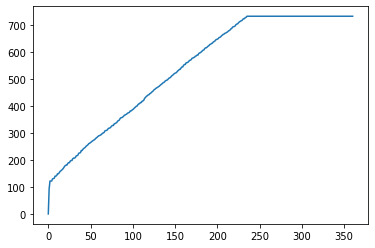

734 total pages downloaded till now & 29 threads are active, 1 x10 sec
734 total pages downloaded till now & 29 threads are active, 2 x10 sec
734 total pages downloaded till now & 29 threads are active, 3 x10 sec
734 total pages downloaded till now & 29 threads are active, 4 x10 sec
734 total pages downloaded till now & 29 threads are active, 5 x10 sec
734 total pages downloaded till now & 29 threads are active, 6 x10 sec
734 total pages downloaded till now & 29 threads are active, 7 x10 sec
734 total pages downloaded till now & 29 threads are active, 8 x10 sec
734 total pages downloaded till now & 29 threads are active, 9 x10 sec
734 total pages downloaded till now & 29 threads are active, 10 x10 sec
734 total pages downloaded till now & 29 threads are active, 11 x10 sec
734 total pages downloaded till now & 29 threads are active, 12 x10 sec
734 total pages downloaded till now & 29 threads are active, 13 x10 sec
734 total pages downloaded till now & 29 threads are active, 14 x10 sec
7

In [ ]:
print("The Crawler has the following configuraions:")
print(conf)

base_url = conf["base_url"]
number_of_threads = conf["number_of_threads"]

url_lock = threading.Lock()


have_visited = []
crawler_threads = []
error_links = []

count_downloaded_pages()

before_starting = datetime.now()

links_to_crawl=[] 

for i in range(int(number_of_threads)):
    print("Setup thread no.{} with the following settings:\nbase_url:{}".format(i,base_url[i]))
    links_to_crawl.append(MyPriorityQueue())
    links_to_crawl[i].put(base_url[i],1)
    have_visited.append({})
    error_links.append([])
    crawler = Crawler(base_url = base_url[i],
                      url_queue = links_to_crawl[i], 
                      have_visited= have_visited[i],
                      error_links= error_links[i],
                      url_lock=url_lock,
                      thread_num = i)
    crawler.name = "crawler"
    classifier = Classifier()

    crawler.start()
    classifier.name="classifer"
    classifier.start()
    crawler_threads.append(crawler)
    crawler_threads.append(classifier)
for crawler in crawler_threads:
    crawler.join()